In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def _extract_series(data, ticker, field_candidates):
    """
    Return a pd.Series for the given ticker by trying a few field names
    and handling both MultiIndex and 'group_by="ticker"' layouts.
    """
    cols = data.columns
    if isinstance(cols, pd.MultiIndex):
        # MultiIndex, e.g., ('Close','SPY') or ('Adj Close','SPY')
        for f in field_candidates:
            key = (f, ticker)
            if key in cols:
                return data[key].rename(ticker)
        # some yfinance versions flip the levels: ('SPY','Close')
        for f in field_candidates:
            key = (ticker, f)
            if key in cols:
                return data[key].rename(ticker)
    else:
        # Per-ticker blocks: data[ticker]['Close'] / ['Adj Close']
        if ticker in data:
            block = data[ticker]
            for f in field_candidates:
                if isinstance(block, pd.Series):
                    # single column edge case
                    if block.name == f:
                        return block.rename(ticker)
                elif f in block:
                    return block[f].rename(ticker)
        # Flat single-level columns (rare): 'SPY' alone
        if ticker in cols:
            return data[ticker].rename(ticker)
    raise KeyError(f"Could not find fields {field_candidates} for {ticker}")

def prepare_data(
    tickers=("SPY","TLT","DBC","^IRX"),
    start="2006-01-01",
    end="2025-09-03",
    interval="1d",
    trading_days=252,
    auto_adjust=True
):
    """
    Returns:
      prices_risky: adjusted prices for risky ETFs (SPY/TLT/DBC)
      rets_log: daily log returns of risky ETFs
      rf_daily: daily risk-free rate (decimal) from ^IRX
    """
    # If auto_adjust=True, adjusted prices are under 'Close'
    price_fields = ["Close"] if auto_adjust else ["Adj Close", "Close"]

    data = yf.download(
        tickers=list(tickers),
        start=start, end=end, interval=interval,
        auto_adjust=auto_adjust, progress=False,
        group_by="column"   # yields MultiIndex columns in most recent yfinance
    )

    # Build series dict
    series = {}
    for t in tickers:
        if t == "^IRX":
            # ^IRX is a yield series; grab Close (or fallback)
            s = _extract_series(data, t, ["Close", "Adj Close"]).rename(t)
        else:
            s = _extract_series(data, t, price_fields).rename(t)
        series[t] = s

    df = pd.concat(series.values(), axis=1).sort_index()
    df.index = pd.to_datetime(df.index)

    # Split risky prices vs IRX yield
    risky_cols = [t for t in tickers if t != "^IRX"]
    if "^IRX" not in df.columns:
        raise KeyError("Risk-free series ^IRX not found in downloaded data.")

    prices_risky = df[risky_cols].ffill()

    # Convert IRX % → daily decimal rate
    rf_annual = (df["^IRX"] / 100.0).ffill()
    rf_daily = (1.0 + rf_annual)**(1.0 / trading_days) - 1.0
    rf_daily = rf_daily.reindex(prices_risky.index).ffill()

    # Compute log returns AFTER aligning prices
    rets_log = np.log(prices_risky).diff().dropna()
    # Align rf to returns index
    rf_daily = rf_daily.reindex(rets_log.index).ffill()

    return prices_risky.loc[rets_log.index], rets_log, rf_daily

In [9]:
prices_df, logrets_df, rf_daily = prepare_data(
    tickers=("SPY","TLT","DBC","^IRX"),
    start="2006-01-01",
    end="2025-09-03",
    interval="1d",
    trading_days=252
)

m_prices = prices_df.resample('ME').last()
m_rets   = m_prices.pct_change().dropna()
m_rf = rf_daily.resample("ME").apply(lambda x: (x + 1).prod() - 1)
m_rf = m_rf.reindex(m_rets.index).ffill()

#single risky asset SPY
ret_spy = m_rets['SPY']

In [15]:
#RED + REDD-COPS for single risky asset

def rolling_economic_drawdown(wealth: pd.Series,
                              rf_monthly: pd.Series,
                              H: int = 12) -> pd.Series:
    """
    REDD_t = 1 - W_t / REM_t
    REM_t = max_{t-H+1 <= s <= t} [ W_s * Π_{j=s+1..t} (1 + rf_j) ]

    Computed in log space for numerical stability:
      log g_t = Σ log(1 + rf_j)
      log REM_t = log g_t + max_{s in window}( log W_s - log g_s )
      REDD_t = 1 - exp( log W_t - log REM_t )
    """
    W = wealth.astype(float).copy()
    rf = rf_monthly.reindex(W.index).fillna(0.0)

    # Guard against non-positive wealth (would make logs invalid)
    W = W.clip(lower=1e-12)

    # Risk-free growth index in logs
    log_g = np.log1p(rf).cumsum()

    # Rolling max of (log W - log g) over the last H months
    base = (np.log(W) - log_g).rolling(window=H, min_periods=1).max()

    # log REM and REDD
    log_REM = log_g + base
    REDD = 1.0 - np.exp(np.log(W) - log_REM)

    return REDD.clip(lower=0.0)


def run_redd_cops_single(
    ret_risky: pd.Series,          # monthly simple returns of the risky asset
    rf_monthly: pd.Series,         # monthly simple RF returns
    sharpe_r: float = 0.5,         # λ
    vol: float = 0.15,             # σ
    delta: float = 0.20,
    H: int = 12,
    w_cap: float = 3.0
) -> tuple[pd.Series, pd.Series, pd.Series]:
    """
    REDD-COPS single-asset (Eq. 5):
      x_t = max{ 0,  [(λ/σ + 1/2)/(1 - δ^2)] * ((δ - REDD_{t-1})/(1 - REDD_{t-1})) }
    Wealth update with simple monthly returns.
    """
    idx = ret_risky.index
    rf = rf_monthly.reindex(idx).fillna(0.0)

    # constant term from Eq. (5)
    const = (sharpe_r / vol + 0.5) / (1.0 - delta**2)

    W = pd.Series(index=idx, dtype=float)
    w = pd.Series(index=idx, dtype=float)

    # t=0
    redd_prev = 0.0
    adj = (delta - redd_prev) / (1.0 - redd_prev)
    w.iloc[0] = np.clip(max(0.0, const * adj), 0.0, w_cap)
    W.iloc[0] = 1.0 * (1.0 + w.iloc[0]*ret_risky.iloc[0] + (1.0 - w.iloc[0])*rf.iloc[0])

    for t in range(1, len(idx)):
        # compute REDD up to t-1 from realized wealth
        REDD_hist = rolling_economic_drawdown(W.iloc[:t], rf.iloc[:t], H=H)
        redd_prev = float(REDD_hist.iloc[-1])
        adj = (delta - redd_prev) / max(1e-12, (1.0 - redd_prev))  # guard div-by-zero

        w_t = np.clip(max(0.0, const * adj), 0.0, w_cap)
        w.iloc[t] = w_t

        W.iloc[t] = W.iloc[t-1] * (1.0 + w_t*ret_risky.iloc[t] + (1.0 - w_t)*rf.iloc[t])

    REDD = rolling_economic_drawdown(W, rf, H=H)
    return W, w, REDD

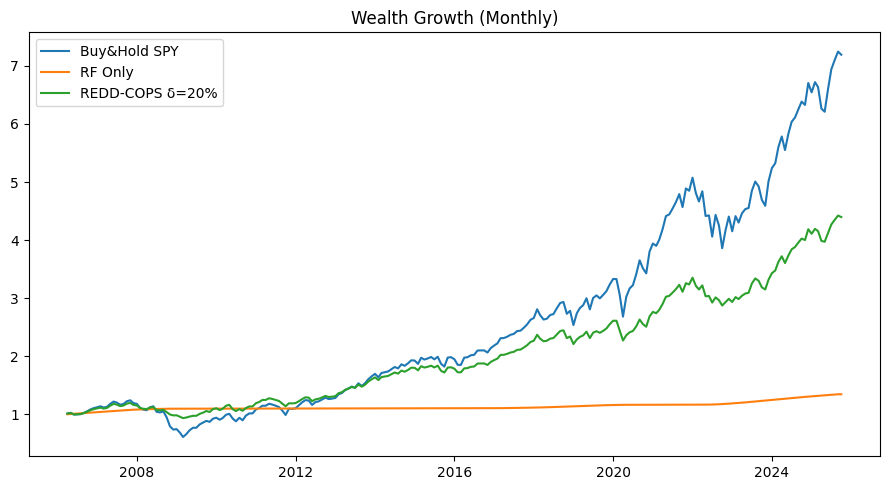

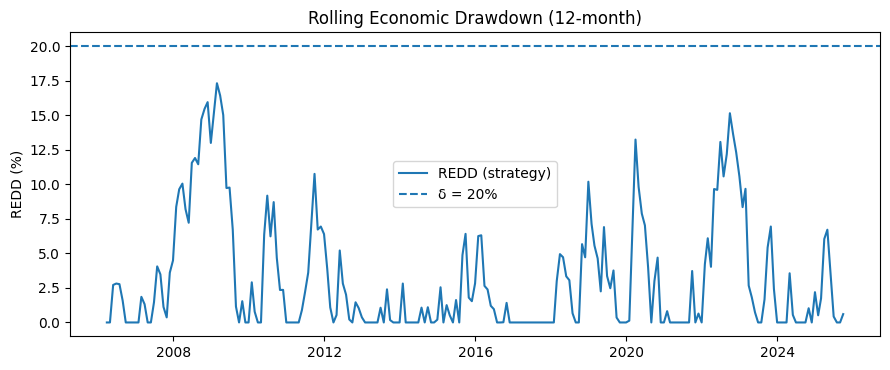

In [16]:
# month end series
px_m  = prices_df["SPY"].resample("ME").last()
ret_m = px_m.pct_change().dropna()                  # simple monthly returns

# Risk-free: compound daily RF to effective monthly (no double +1), align
rf_m   = m_rf
m_rf.name = "RF_m"

# Benchmarks
W_spy = (1 + ret_m).cumprod().rename("Buy&Hold SPY")
W_rf  = (1 + m_rf).cumprod().rename("RF Only")

# REDD-COPS single-asset 
DELTA  = 0.20   # drawdown budget
H_WIN  = 12     # months
SHARPE = 0.5    # λ  (same frequency basis as VOL)
VOL    = 0.15   # σ

W_strat, w_strat, REDD_strat = run_redd_cops_single(
    ret_risky=ret_m,
    rf_monthly=m_rf,
    sharpe_r=SHARPE,
    vol=VOL,
    delta=DELTA,
    H=H_WIN,
    w_cap=1.5
)
W_strat = W_strat.rename(f"REDD-COPS δ={int(DELTA*100)}%")

# wealth plots 
plt.figure(figsize=(9,5))
plt.plot(W_spy,   label=W_spy.name)
plt.plot(W_rf,    label=W_rf.name)
plt.plot(W_strat, label=W_strat.name)
plt.title("Wealth Growth (Monthly)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,3.8))
plt.plot(100 * REDD_strat, label="REDD (strategy)")
plt.axhline(100 * DELTA, linestyle="--", label=f"δ = {int(DELTA*100)}%")
plt.ylabel("REDD (%)"); plt.title(f"Rolling Economic Drawdown ({H_WIN}-month)")
plt.legend(); plt.tight_layout(); plt.show()


In [17]:
# performance metrics for single risky asset

def max_drawdown(W: pd.Series) -> float:
    peak = W.cummax()
    dd = W/peak - 1.0
    return -dd.min()

def ann_return_from_r(r: pd.Series, periods_per_year=12) -> float:
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    return (1.0 + r).prod() ** (periods_per_year/len(r)) - 1.0

def ann_vol_from_r(r: pd.Series, periods_per_year=12) -> float:
    r = r.dropna()
    return r.std(ddof=1) * np.sqrt(periods_per_year)

def sharpe_annual(r: pd.Series, rf: pd.Series, periods_per_year=12) -> float:
    r = r.dropna()
    rf = rf.reindex(r.index).fillna(0.0)
    vol_m = r.std(ddof=1)
    if vol_m == 0 or np.isnan(vol_m):
        return np.nan
    ex = r - rf
    return ex.mean()/vol_m * np.sqrt(periods_per_year)

def ending_multiple(W: pd.Series) -> float:
    return float(W.iloc[-1] / W.iloc[0])

# strategy runner with optional exposure scale ("1/3 REDD-COPS") 
def run_redd_variant(ret_risky: pd.Series, rf_m: pd.Series,
                     delta: float, sharpe_r: float, vol: float,
                     H: int = 12, w_cap: float = 3.0,
                     scale: float = 1.0):
    """
    scale < 1.0 lets you replicate '1/3 REDD-COPS' by scaling exposures x_t -> scale * x_t
    """
    # run equation 5 (redd-cops for single risky asset)
    W, w, REDD = run_redd_cops_single(
        ret_risky=ret_risky, rf_monthly=rf_m,
        sharpe_r=sharpe_r, vol=vol, delta=delta, H=H, w_cap=w_cap
    )
    if scale != 1.0:
        # rebuild wealth using scaled weights against the same returns
        idx = ret_risky.index
        rf = rf_m.reindex(idx).fillna(0.0)
        W_scaled = pd.Series(index=idx, dtype=float)
        W_scaled.iloc[0] = 1.0 * (1.0 + (scale*w.iloc[0])*ret_risky.iloc[0] + (1.0 - scale*w.iloc[0])*rf.iloc[0])
        for t in range(1, len(idx)):
            rR, rF = ret_risky.iloc[t], rf.iloc[t]
            x = np.clip(scale * w.iloc[t], 0.0, w_cap)
            W_scaled.iloc[t] = W_scaled.iloc[t-1] * (1.0 + x*rR + (1.0 - x)*rF)
        # recompute REDD on realized wealth with same H
        REDD_scaled = rolling_economic_drawdown(W_scaled, rf, H=H)
        return W_scaled.rename(W.name if W.name else "Wealth"), (scale*w).clip(0, w_cap), REDD_scaled
    return W, w, REDD

# Table 1: Calibrated REDD-COPS of Single Risky Asset (SPTR)
def table1_monthly(ret_m: pd.Series, rf_m: pd.Series,
                   sharpe_r: float, vol: float,
                   deltas=(np.nan, 1/3, 0.25, 0.20, 0.15),
                   labels=("SPTR","1/3 REDD-COPS","25% REDD-COPS","20% REDD-COPS","15% REDD-COPS"),
                   H=12, w_cap=3.0) -> pd.DataFrame:
    rows = []

    # SPTR (buy & hold risky asset)
    W_sptr = (1 + ret_m).cumprod().rename("SPTR")
    REDD_sptr = rolling_economic_drawdown(W_sptr, rf_m, H=H)
    met = {
        "Annualized Return": ann_return_from_r(ret_m),
        "Annualized Std Deviation": ann_vol_from_r(ret_m),
        "Max REDD": REDD_sptr.max(),
        "Average REDD": REDD_sptr.mean(),
        "Max Drawdown": max_drawdown(W_sptr),
        "Sharpe Ratio": sharpe_annual(ret_m, rf_m),
        "Average Total Exposure": 1.0,
        "Max Total Exposure": 1.0,
        "Ending Multiple": ending_multiple(W_sptr),
        "Skew": ret_m.skew(),
        "Excess Kurtosis": ret_m.kurt()  
    }
    rows.append(pd.Series(met, name="SPTR"))

    # 1/3 REDD-COPS
    W13, w13, REDD13 = run_redd_variant(ret_m, rf_m, delta=0.20, sharpe_r=sharpe_r, vol=vol, H=H, w_cap=w_cap, scale=1/3)
    r13 = W13.pct_change().dropna()
    rows.append(pd.Series({
        "Annualized Return": ann_return_from_r(r13),
        "Annualized Std Deviation": ann_vol_from_r(r13),
        "Max REDD": REDD13.max(),
        "Average REDD": REDD13.mean(),
        "Max Drawdown": max_drawdown(W13),
        "Sharpe Ratio": sharpe_annual(r13, rf_m),
        "Average Total Exposure": w13.mean(),
        "Max Total Exposure": w13.max(),
        "Ending Multiple": ending_multiple(W13),
        "Skew": r13.skew(),
        "Excess Kurtosis": r13.kurt()
    }, name="1/3 REDD-COPS"))

    # Parametric REDD-COPS across δ = 25%, 20%, 15%
    for d, lab in [(0.25, "25% REDD-COPS"), (0.20, "20% REDD-COPS"), (0.15, "15% REDD-COPS")]:
        Wd, wd, REDDd = run_redd_variant(ret_m, rf_m, delta=d, sharpe_r=sharpe_r, vol=vol, H=H, w_cap=w_cap, scale=1.0)
        rd = Wd.pct_change().dropna()
        rows.append(pd.Series({
            "Annualized Return": ann_return_from_r(rd),
            "Annualized Std Deviation": ann_vol_from_r(rd),
            "Max REDD": REDDd.max(),
            "Average REDD": REDDd.mean(),
            "Max Drawdown": max_drawdown(Wd),
            "Sharpe Ratio": sharpe_annual(rd, rf_m),
            "Average Total Exposure": wd.mean(),
            "Max Total Exposure": wd.max(),
            "Ending Multiple": ending_multiple(Wd),
            "Skew": rd.skew(),
            "Excess Kurtosis": rd.kurt()
        }, name=lab))

    df = pd.DataFrame(rows)
    # Pretty formatting like the paper
    pct_cols = ["Annualized Return","Annualized Std Deviation","Max REDD","Average REDD",
                "Max Drawdown","Average Total Exposure","Max Total Exposure"]
    fmt = df.copy()
    fmt[pct_cols] = (fmt[pct_cols]*100).round(2).astype(str) + "%"
    fmt["Sharpe Ratio"] = df["Sharpe Ratio"].round(3)
    fmt["Ending Multiple"] = df["Ending Multiple"].round(1)
    fmt["Skew"] = df["Skew"].round(3)
    fmt["Excess Kurtosis"] = df["Excess Kurtosis"].round(3)
    return fmt

table1 = table1_monthly(
    ret_m=ret_m,
    rf_m=m_rf,
    sharpe_r=0.5, 
    vol=0.15,       
    H=12,
    w_cap=1.5      
)
print(table1)


              Annualized Return Annualized Std Deviation Max REDD  \
SPTR                      10.6%                    15.2%   46.65%   
1/3 REDD-COPS             3.67%                    3.01%    6.07%   
25% REDD-COPS             9.49%                   11.48%   21.85%   
20% REDD-COPS             7.81%                    8.94%   17.32%   
15% REDD-COPS              6.2%                    6.56%   12.88%   

              Average REDD Max Drawdown  Sharpe Ratio Average Total Exposure  \
SPTR                 4.65%       50.78%         0.641                 100.0%   
1/3 REDD-COPS        1.07%        6.63%         0.712                  22.9%   
25% REDD-COPS        4.08%       27.74%         0.718                  88.1%   
20% REDD-COPS        3.18%       21.85%         0.719                 68.69%   
15% REDD-COPS        2.34%       15.97%         0.720                 50.47%   

              Max Total Exposure  Ending Multiple   Skew  Excess Kurtosis  
SPTR                      10

In [18]:
#redd cops double risky assets

def run_redd_cops_double(
    ret1: pd.Series,                # monthly simple returns risky asset 1
    ret2: pd.Series,                # monthly simple returns risky asset 2
    rf_monthly: pd.Series,          # monthly simple RF returns
    lam1: float, lam2: float,       # λ1, λ2   (same freq basis as σ)
    sig1: float, sig2: float,       # σ1, σ2   (monthly if lam is monthly)
    rho: float,                     # correlation between risky returns
    delta: float = 0.20,            # drawdown budget
    H: int = 12,                    # months for REDD
    w_cap_per_asset: float | None = None,  # optional per-asset cap
    w_cap_total: float | None = None       # optional total cap (leverage limit)
) -> tuple[pd.Series, pd.DataFrame, pd.Series]:
    """
    Implements REDD-COPS for 2 risky assets (Eq. 6).
    x_t vector is:
      x = C * v  where
      v = [v1, v2]^T with
          v1 = (λ1 + 0.5σ1 - ρ*(λ2 + 0.5σ2)*σ1/σ2)
          v2 = (λ2 + 0.5σ2 - ρ*(λ1 + 0.5σ1)*σ2/σ1)
      C = (1/(1-ρ^2)) * max(0, (1/(1-δ^2)) * ((δ - REDD_{t-1})/(1 - REDD_{t-1})))
    Wealth update: W_t = W_{t-1} * (1 + x1 r1_t + x2 r2_t + (1 - x1 - x2) rF_t)
    """
    # Align indices
    idx = ret1.index.intersection(ret2.index)
    idx = idx.intersection(rf_monthly.index)
    r1 = ret1.reindex(idx).astype(float)
    r2 = ret2.reindex(idx).astype(float)
    rF = rf_monthly.reindex(idx).fillna(0.0).astype(float)

    # Precompute the constant vector v (doesn't depend on t)
    v1 = (lam1 + 0.5*sig1) - rho * (lam2 + 0.5*sig2) * (sig1 / sig2)
    v2 = (lam2 + 0.5*sig2) - rho * (lam1 + 0.5*sig1) * (sig2 / sig1)
    v = np.array([v1, v2], dtype=float)

    # Containers
    W = pd.Series(index=idx, dtype=float)
    w = pd.DataFrame(index=idx, columns=["x1","x2"], dtype=float)

    # t=0 weight (REDD_{-1}=0 -> scale0 = δ/(1-0)/(1-δ^2))
    scale0 = max(0.0, (1.0/(1.0 - delta**2)) * (delta / 1.0))
    C0 = scale0 / (1.0 - rho**2)
    x0 = C0 * v
    # Apply caps if provided
    if w_cap_per_asset is not None:
        x0 = np.clip(x0, 0.0, w_cap_per_asset)
    if w_cap_total is not None:
        tot = x0.sum()
        if tot > w_cap_total and tot > 0:
            x0 = x0 * (w_cap_total / tot)

    w.iloc[0] = x0
    W.iloc[0] = 1.0 * (1.0 + x0[0]*r1.iloc[0] + x0[1]*r2.iloc[0] + (1.0 - x0.sum())*rF.iloc[0])

    # Iterate
    for t in range(1, len(idx)):
        # REDD on realized wealth up to t-1
        REDD_hist = rolling_economic_drawdown(W.iloc[:t], rF.iloc[:t], H=H)
        redd_prev = float(REDD_hist.iloc[-1]) if len(REDD_hist) else 0.0

        # Eq.(6) scale term
        scale = max(0.0, (1.0/(1.0 - delta**2)) * ((delta - redd_prev) / max(1e-12, (1.0 - redd_prev))))
        C = scale / (1.0 - rho**2)

        x = C * v
        if w_cap_per_asset is not None:
            x = np.clip(x, 0.0, w_cap_per_asset)
        if w_cap_total is not None:
            tot = x.sum()
            if tot > w_cap_total and tot > 0:
                x = x * (w_cap_total / tot)

        w.iloc[t] = x
        W.iloc[t] = W.iloc[t-1] * (1.0 + x[0]*r1.iloc[t] + x[1]*r2.iloc[t] + (1.0 - x.sum())*rF.iloc[t])

    REDD = rolling_economic_drawdown(W, rF, H=H)
    return W.rename("Wealth"), w.rename(columns={"x1":"Risky Asset 1","x2":"Risky Asset 2"}), REDD

# Edited/Added Code Starts Here

In [19]:
# redd cops double risky assets with rolling covariance

def run_redd_cops_double_with_rolling_covariance(
    ret1: pd.Series,                # monthly simple returns risky asset 1
    ret2: pd.Series,                # monthly simple returns risky asset 2
    rf_monthly: pd.Series,          # monthly simple RF returns
    lam1: float, lam2: float,       # λ1, λ2   (same freq basis as σ)
    cov_window: int = 12,           # rolling window for covariance
    delta: float = 0.20,            # drawdown budget
    H: int = 12,                    # months for REDD
    w_cap_per_asset: float | None = None,  # optional per-asset cap
    w_cap_total: float | None = None       # optional total cap (leverage limit)
) -> tuple[pd.Series, pd.DataFrame, pd.Series]:
    # Align indices
    idx = ret1.index.intersection(ret2.index)
    idx = idx.intersection(rf_monthly.index)
    r1 = ret1.reindex(idx).astype(float)
    r2 = ret2.reindex(idx).astype(float)
    rF = rf_monthly.reindex(idx).fillna(0.0).astype(float)

    v = np.array([0.0, 0.0], dtype=float)  # Wealth initially only allocated to risk-free asset
    
    # Containers
    W = pd.Series(index=idx, dtype=float)
    w = pd.DataFrame(index=idx, columns=["x1","x2"], dtype=float)

    # Initial conditions
    W.iloc[0] = 1.0
    w.iloc[0] = v

    for t in range(1, len(idx)):
         # REDD on realized wealth up to t-1
        REDD_hist = rolling_economic_drawdown(W.iloc[:t], rF.iloc[:t], H=H)
        redd_prev = float(REDD_hist.iloc[-1]) if len(REDD_hist) else 0.0

        # Eq.(6) scale term
        scale = max(0.0, (1.0/(1.0 - delta**2)) * ((delta - redd_prev) / max(1e-12, (1.0 - redd_prev))))

        # Rolling window of returns
        r1_window = r1.iloc[max(0, t - cov_window):t]
        r2_window = r2.iloc[max(0, t - cov_window):t]
        r_window = pd.concat([r1_window, r2_window], axis=1)

        # Not enough data so go risk-free
        if len(r_window) < 2:
            w.iloc[t] = 0.0
            W.iloc[t] = W.iloc[t - 1] * (1.0 + rF.iloc[t])
            continue

        # Sample covariance
        Sigma = r_window.cov().values

        try:
            Sigma_inv = np.linalg.inv(Sigma)
        except np.linalg.LinAlgError:
            # Singular covariance so de-risk
            w.iloc[t] = 0.0
            W.iloc[t] = W.iloc[t - 1] * (1.0 + rF.iloc[t])
            continue

        # v_t = λ + 0.5·diag(Σ_t)
        sig = np.sqrt(np.clip(np.diag(Sigma), 0.0, np.inf))
        v = np.array([lam1 + 0.5 * sig[0], lam2 + 0.5 * sig[1]], dtype=float)

        # Core REDD-COPS equation
        x = scale * (Sigma_inv @ v)

        # Per-asset cap
        if w_cap_per_asset is not None:
            x = np.clip(x, 0.0, w_cap_per_asset)

        # Total exposure cap
        if w_cap_total is not None:
            tot = x.sum()
            if tot > w_cap_total and tot > 0:
                x *= w_cap_total / tot

        w.iloc[t] = x
        W.iloc[t] = W.iloc[t-1] * (1.0 + x[0]*r1.iloc[t] + x[1]*r2.iloc[t] + (1.0 - x.sum())*rF.iloc[t])

    REDD = rolling_economic_drawdown(W, rF, H=H)
    return W.rename("Wealth"), w.rename(columns={"x1":"Risky Asset 1","x2":"Risky Asset 2"}), REDD

In [20]:
#60/40 balanced portfolio for double risky assets (with equal allocation to both risky assets)

def run_double_fixed_weights(
    ret1: pd.Series,                # monthly simple returns risky asset 1
    ret2: pd.Series,                # monthly simple returns risky asset 2
    rf_monthly: pd.Series,          # monthly simple RF returns
    w1: float = 0.3, # fixed weight for first risky asset
    w2: float = 0.3,  # fixed weight for second risky asset
    H: int = 12,                    # months
    w_cap_per_asset: float | None = None,  # optional per-asset cap
    w_cap_total: float | None = None       # optional total cap (leverage limit
) -> tuple[pd.Series, pd.DataFrame, pd.Series]:
    """
    Implements a fixed-weight portfolio for two risky assets with (w1 and w2 as the fixed weights for each risky asset).
    Wealth update: W_t = w1 * (1 + r1_t) + w2 * (1 + r2_t) + (1 - w1 - w2) * (1 + rF_t)
    """
    # Align indices
    idx = ret1.index.intersection(ret2.index)
    idx = idx.intersection(rf_monthly.index)
    r1 = ret1.reindex(idx).astype(float)
    r2 = ret2.reindex(idx).astype(float)
    rF = rf_monthly.reindex(idx).fillna(0.0).astype(float)

    # Containers
    W = pd.Series(index=idx, dtype=float)
    w = pd.DataFrame(index=idx, columns=["x1","x2","xF"], dtype=float)

    w["x1"] = w1
    w["x2"] = w2
    w["xF"] = 1.0 - (w1 + w2)
    W.iloc[0] = 1.0 * (1.0 + w1 * r1.iloc[0] + w2 * r2.iloc[0] + (1.0 - (w1 + w2)) * rF.iloc[0])

    # Iterate
    for t in range(1, len(idx)):
        # Obtain wealth contributions
        w.iloc[t]["x1"] = w.iloc[t-1]["x1"] * (1.0 + r1.iloc[t])
        w.iloc[t]["x2"] = w.iloc[t-1]["x2"] * (1.0 + r2.iloc[t])
        w.iloc[t]["xF"] = w.iloc[t-1]["xF"] * (1.0 + rF.iloc[t])

        W.iloc[t] = w.iloc[t]["x1"] + w.iloc[t]["x2"] + w.iloc[t]["xF"]

        # Normalize to get weights
        w.iloc[t]["x1"] = w.iloc[t]["x1"] / W.iloc[t]
        w.iloc[t]["x2"] = w.iloc[t]["x2"] / W.iloc[t]
        w.iloc[t]["xF"] = w.iloc[t]["xF"] / W.iloc[t]

    # Drop xF column as not needed
    w.drop(columns=["xF"], inplace=True)

    REDD = rolling_economic_drawdown(W, rF, H=H)
    return W.rename("60/40 Portfolio"), w.rename(columns={"x1":"Risky Asset 1","x2":"Risky Asset 2"}), REDD

In [21]:
#60/40 balanced portfolio for double risky assets with monthly rebalance (with equal allocation to both risky assets)

def run_double_fixed_weights_with_rebalance(
    ret1: pd.Series,                # monthly simple returns risky asset 1
    ret2: pd.Series,                # monthly simple returns risky asset 2
    rf_monthly: pd.Series,          # monthly simple RF returns
    w1: float = 0.3, # fixed weight for first risky asset
    w2: float = 0.3,  # fixed weight for second risky asset
    H: int = 12,                    # months
) -> tuple[pd.Series, pd.DataFrame, pd.Series]:
    """
    Implements a fixed-weight portfolio for two risky assets with (w1 and w2 as the fixed weights for each risky asset).
    Wealth update: W_t = W_{t-1} * (1 + w1 r1_t + w2 r2_t + (1 - w1 - w2) rF_t)
    """
    # Align indices
    idx = ret1.index.intersection(ret2.index)
    idx = idx.intersection(rf_monthly.index)
    r1 = ret1.reindex(idx).astype(float)
    r2 = ret2.reindex(idx).astype(float)
    rF = rf_monthly.reindex(idx).fillna(0.0).astype(float)

    # Containers
    W = pd.Series(index=idx, dtype=float)
    w = pd.DataFrame(index=idx, columns=["x1","x2"], dtype=float)

    w["x1"] = w1
    w["x2"] = w2
    W.iloc[0] = 1.0 * (1.0 + w1 * r1.iloc[0] + w2 * r2.iloc[0] + (1.0 - (w1 + w2)) * rF.iloc[0])

    # Iterate
    for t in range(1, len(idx)):
        w.iloc[t] = w.iloc[0]  # fixed weights
        W.iloc[t] = W.iloc[t-1] * (1.0 + w1 * r1.iloc[t] + w2 * r2.iloc[t] + (1.0 - (w1 + w2)) * rF.iloc[t])

    REDD = rolling_economic_drawdown(W, rF, H=H)
    return W.rename("60/40 Portfolio with monthly rebalancing"), w.rename(columns={"x1":"Risky Asset 1","x2":"Risky Asset 2"}), REDD

In [22]:
#MVP for double risky assets

def run_mvp_double(
    ret1: pd.Series,                # monthly simple returns risky asset 1
    ret2: pd.Series,                # monthly simple returns risky asset 2
    rf_monthly: pd.Series,          # monthly simple RF returns
    sig1: float, sig2: float,       # σ1, σ2   (monthly if lam is monthly)
    rho: float,                     # correlation between risky returns
    H: int = 12,                    # months
    w_cap_per_asset: float | None = None,  # optional per-asset cap
    w_cap_total: float | None = None       # optional total cap (leverage limit)       
) -> tuple[pd.Series, pd.DataFrame, pd.Series]:
    """
    Implements Minimum Variance Portfolio for two risky assets.
    Minimum Variance Portfolio weights (closed-form):
      w1 = (σ2^2 - ρ σ1 σ2) / (σ1^2 + σ2^2 - 2 ρ σ1 σ2)
      w2 = 1 - w1
    Wealth update: W_t = W_{t-1} * (1 + w1 r1_t + w2 r2_t + (1 - w1 - w2) rF_t)
    """
    # Align indices
    idx = ret1.index.intersection(ret2.index)
    idx = idx.intersection(rf_monthly.index)
    r1 = ret1.reindex(idx).astype(float)
    r2 = ret2.reindex(idx).astype(float)
    rF = rf_monthly.reindex(idx).fillna(0.0).astype(float)

    # Calculate MVP weights (with closed-form solution) for two risky assets
    denom = sig1**2 + sig2**2 - 2*rho*sig1*sig2
    w1 = (sig2**2 - rho*sig1*sig2) / denom
    w2 = 1 - w1

    # Precompute the constant vector v (doesn't depend on t)
    v = np.array([w1, w2], dtype=float)

    # Containers
    W = pd.Series(index=idx, dtype=float)
    w = pd.DataFrame(index=idx, columns=["x1","x2"], dtype=float)

    # Apply caps if provided
    if w_cap_per_asset is not None:
        v = np.clip(v, 0.0, w_cap_per_asset)
    if w_cap_total is not None:
        tot = v.sum()
        if tot > w_cap_total and tot > 0:
            v = v * (w_cap_total / tot)

    w["x1"] = v[0]
    w["x2"] = v[1]
    W.iloc[0] = 1.0 * (1.0 + v[0]*r1.iloc[0] + v[1]*r2.iloc[0] + (1.0 - v.sum())*rF.iloc[0])
    
    # Iterate
    for t in range(1, len(idx)):
        w.iloc[t] = w.iloc[0]  # fixed weights
        W.iloc[t] = W.iloc[t-1] * (1.0 + w1 * r1.iloc[t] + w2 * r2.iloc[t] + (1.0 - (w1 + w2)) * rF.iloc[t])

    REDD = rolling_economic_drawdown(W, rF, H=H)
    return W.rename("Minimum Variance Portfolio"), w.rename(columns={"x1":"Risky Asset 1","x2":"Risky Asset 2"}), REDD

In [23]:
#MVP for double risky assets with leverage

def run_mvp_double_with_leverage(
    ret1: pd.Series,                # monthly simple returns risky asset 1
    ret2: pd.Series,                # monthly simple returns risky asset 2
    rf_monthly: pd.Series,          # monthly simple RF returns
    sig1: float, sig2: float,       # σ1, σ2   (monthly if lam is monthly)
    rho: float,                     # correlation between risky returns
    L: float,                     # leverage factor
    H: int = 12,                    # months
    w_cap_per_asset: float | None = None,  # optional per-asset cap
    w_cap_total: float | None = None       # optional total cap (leverage limit)       
) -> tuple[pd.Series, pd.DataFrame, pd.Series]:
    """
    Implements Minimum Variance Portfolio for two risky assets.
    Minimum Variance Portfolio weights (closed-form):
      w1 = ((σ2^2 - ρ σ1 σ2) / (σ1^2 + σ2^2 - 2 ρ σ1 σ2)) * L
      w2 = (1 - w1) * L
    Wealth update: W_t = W_{t-1} * (1 + w1 r1_t + w2 r2_t + (1 - w1 - w2) rF_t)
    """
    # Align indices
    idx = ret1.index.intersection(ret2.index)
    idx = idx.intersection(rf_monthly.index)
    r1 = ret1.reindex(idx).astype(float)
    r2 = ret2.reindex(idx).astype(float)
    rF = rf_monthly.reindex(idx).fillna(0.0).astype(float)

    # Calculate MVP weights (with closed-form solution) for two risky assets
    denom = sig1**2 + sig2**2 - 2*rho*sig1*sig2
    w1 = (sig2**2 - rho*sig1*sig2) / denom
    w2 = 1 - w1

    # Precompute the constant vector v (doesn't depend on t)
    v = np.array([w1, w2], dtype=float)
    v *= L  # apply leverage

    # Containers
    W = pd.Series(index=idx, dtype=float)
    w = pd.DataFrame(index=idx, columns=["x1","x2"], dtype=float)

    # Apply caps if provided
    if w_cap_per_asset is not None:
        v = np.clip(v, 0.0, w_cap_per_asset)
    if w_cap_total is not None:
        tot = v.sum()
        if tot > w_cap_total and tot > 0:
            v = v * (w_cap_total / tot)

    w["x1"] = v[0]
    w["x2"] = v[1]
    W.iloc[0] = 1.0 * (1.0 + v[0]*r1.iloc[0] + v[1]*r2.iloc[0] + (1.0 - v.sum())*rF.iloc[0])
    
    # Iterate
    for t in range(1, len(idx)):
        w.iloc[t] = w.iloc[0]  # fixed weights
        W.iloc[t] = W.iloc[t-1] * (1.0 + w1 * r1.iloc[t] + w2 * r2.iloc[t] + (1.0 - (w1 + w2)) * rF.iloc[t])

    REDD = rolling_economic_drawdown(W, rF, H=H)
    return W.rename("Minimum Variance Portfolio"), w.rename(columns={"x1":"Risky Asset 1","x2":"Risky Asset 2"}), REDD

In [24]:
#RPP for double risky assets
def run_rpp_double(
    ret1: pd.Series,                # monthly simple returns risky asset 1
    ret2: pd.Series,                # monthly simple returns risky asset 2
    rf_monthly: pd.Series,          # monthly simple RF returns
    sig1: float, sig2: float,       # σ1, σ2   (monthly if lam is monthly)
    H: int = 12,                    # months
    w_cap_per_asset: float | None = None,  # optional per-asset cap
    w_cap_total: float | None = None       # optional total cap (leverage limit)       
) -> tuple[pd.Series, pd.DataFrame, pd.Series]:
    """
    Implements Risk Parity Portfolio for two risky assets.
    Risk Parity weights (closed-form):
      w1 = abs(σ1 - σ2) / (σ1 + σ2)
      w2 = 1 - w1
    Note: abs used to ensure positive weights even if sig1 < sig2.
    Wealth update: W_t = W_{t-1} * (1 + w1 r1_t + w2 r2_t + (1 - w1 - w2) rF_t)
    """

    # Align indices
    idx = ret1.index.intersection(ret2.index)
    idx = idx.intersection(rf_monthly.index)
    r1 = ret1.reindex(idx).astype(float)
    r2 = ret2.reindex(idx).astype(float)
    rF = rf_monthly.reindex(idx).fillna(0.0).astype(float)

    # Calculate RPP weights (with closed-form solution) for two risky assets
    w1 = abs(sig1 - sig2) / (sig1 + sig2)
    w2 = 1 - w1

    # Precompute the constant vector v (doesn't depend on t)
    v = np.array([w1, w2], dtype=float)

    # Containers
    W = pd.Series(index=idx, dtype=float)
    w = pd.DataFrame(index=idx, columns=["x1","x2"], dtype=float)

    # Apply caps if provided
    if w_cap_per_asset is not None:
        v = np.clip(v, 0.0, w_cap_per_asset)
    if w_cap_total is not None:
        tot = v.sum()
        if tot > w_cap_total and tot > 0:
            v = v * (w_cap_total / tot)

    w["x1"] = v[0]
    w["x2"] = v[1]
    W.iloc[0] = 1.0 * (1.0 + v[0]*r1.iloc[0] + v[1]*r2.iloc[0] + (1.0 - v.sum())*rF.iloc[0])
    
    # Iterate
    for t in range(1, len(idx)):
        w.iloc[t] = w.iloc[0]  # fixed weights
        W.iloc[t] = W.iloc[t-1] * (1.0 + w1 * r1.iloc[t] + w2 * r2.iloc[t] + (1.0 - (w1 + w2)) * rF.iloc[t])

    REDD = rolling_economic_drawdown(W, rF, H=H)
    return W.rename("Risk Parity Portfolio"), w.rename(columns={"x1":"Risky Asset 1","x2":"Risky Asset 2"}), REDD

In [25]:
#RPP for double risky assets with leverage
def run_rpp_double_with_leverage(
    ret1: pd.Series,                # monthly simple returns risky asset 1
    ret2: pd.Series,                # monthly simple returns risky asset 2
    rf_monthly: pd.Series,          # monthly simple RF returns
    sig1: float, sig2: float,       # σ1, σ2   (monthly if lam is monthly)
    L: float = 1.6,                 # leverage factor
    H: int = 12,                    # months
    w_cap_per_asset: float | None = None,  # optional per-asset cap
    w_cap_total: float | None = None       # optional total cap (leverage limit)       
) -> tuple[pd.Series, pd.DataFrame, pd.Series]:
    """
    Implements Risk Parity Portfolio for two risky assets.
    Risk Parity weights (closed-form):
      w1 = (abs(σ1 - σ2) / (σ1 + σ2)) * L
      w2 = (1 - w1) * L
    Note: abs used to ensure positive weights even if sig1 < sig2.
    Wealth update: W_t = W_{t-1} * (1 + w1 r1_t + w2 r2_t + (1 - w1 - w2) rF_t)
    """

    # Align indices
    idx = ret1.index.intersection(ret2.index)
    idx = idx.intersection(rf_monthly.index)
    r1 = ret1.reindex(idx).astype(float)
    r2 = ret2.reindex(idx).astype(float)
    rF = rf_monthly.reindex(idx).fillna(0.0).astype(float)

    # Calculate RPP weights (with closed-form solution) for two risky assets
    w1 = abs(sig1 - sig2) / (sig1 + sig2)
    w2 = 1 - w1

    # Precompute the constant vector v (doesn't depend on t)
    v = np.array([w1, w2], dtype=float)
    v *= L  # apply leverage

    # Containers
    W = pd.Series(index=idx, dtype=float)
    w = pd.DataFrame(index=idx, columns=["x1","x2"], dtype=float)

    # Apply caps if provided
    if w_cap_per_asset is not None:
        v = np.clip(v, 0.0, w_cap_per_asset)
    if w_cap_total is not None:
        tot = v.sum()
        if tot > w_cap_total and tot > 0:
            v = v * (w_cap_total / tot)

    w["x1"] = v[0]
    w["x2"] = v[1]
    W.iloc[0] = 1.0 * (1.0 + v[0]*r1.iloc[0] + v[1]*r2.iloc[0] + (1.0 - v.sum())*rF.iloc[0])
    
    # Iterate
    for t in range(1, len(idx)):
        w.iloc[t] = w.iloc[0]  # fixed weights
        W.iloc[t] = W.iloc[t-1] * (1.0 + w1 * r1.iloc[t] + w2 * r2.iloc[t] + (1.0 - (w1 + w2)) * rF.iloc[t])

    REDD = rolling_economic_drawdown(W, rF, H=H)
    return W.rename("Risk Parity Portfolio with (60%) Leverage"), w.rename(columns={"x1":"Risky Asset 1","x2":"Risky Asset 2"}), REDD

C:\Users\Benedict\AppData\Local\Temp\ipykernel_30092\3076065681.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w.iloc[t]["x1"] = w.iloc[t-1]["x1"] * (1.0 + r1.iloc[t])
C:\Users\Benedict\AppData\Local\Temp\ipykernel_30092\3076065681.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w.iloc[t]["x2"] = w.iloc[t-1]["x2"] * (1.0 + r2.iloc[t])
C:\Users\Benedict\AppData\Local\Temp\ipykernel_30092\3076065681.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

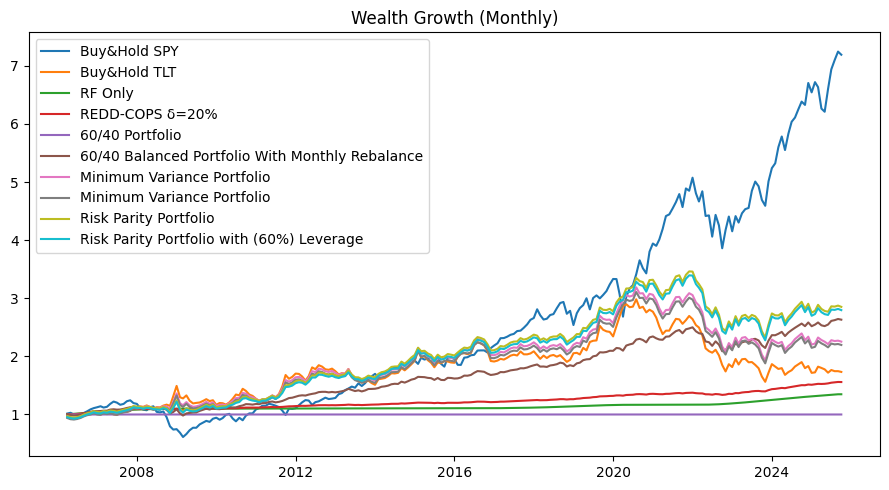

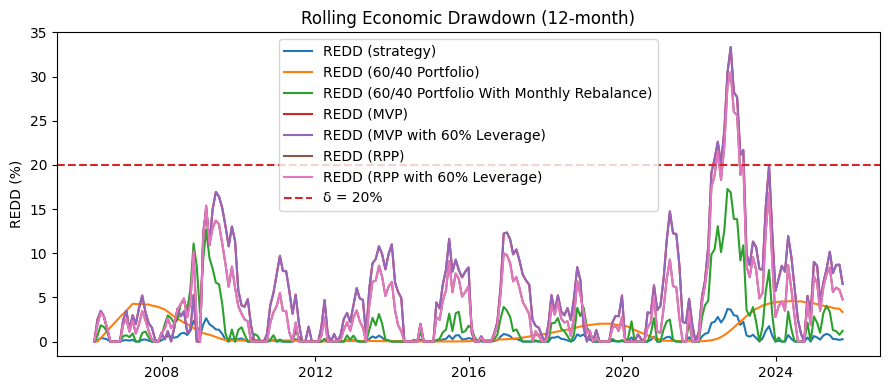

In [26]:
# monthly data/parameters
ret1_m = m_rets["SPY"]
ret2_m = m_rets["TLT"]

DELTA  = 0.20      # drawdown cap (20%)
H_WIN  = 12        # 12-month rolling window
RHO    = 0.3       # correlation between SPY/TLT (example)
SIG1   = 0.045     # monthly vol of SPY (≈15% annual)
SIG2   = 0.025     # monthly vol of TLT (≈8% annual)
LAM1   = 0.45      # monthly Sharpe for SPY (≈1.56 annual Sharpe)
LAM2   = 0.35      # monthly Sharpe for TLT
WCAP   = 1.5       # per-asset cap (150%)

# REDD-COPS double risky asset (Eq. 6)
W_strat, w_strat, REDD_strat = run_redd_cops_double(
    ret1=ret1_m,
    ret2=ret2_m,
    rf_monthly=rf_m,
    lam1=LAM1, lam2=LAM2,
    sig1=SIG1, sig2=SIG2,
    rho=RHO,
    delta=DELTA,
    H=H_WIN,
    w_cap_per_asset=WCAP
)

# REDD-COPS double risky asset with rolling covariance (currently problematic)
W_strat_rc, w_strat_rc, REDD_strat_rc = run_redd_cops_double_with_rolling_covariance(
    ret1=ret1_m,
    ret2=ret2_m,
    rf_monthly=rf_m,
    lam1=LAM1, lam2=LAM2,
    cov_window=12,
    delta=DELTA,
    H=H_WIN,
    w_cap_per_asset=WCAP
)

# 60/40 balanced portfolio benchmark
W_6040, w_6040, REDD_6040 = run_double_fixed_weights(
    ret1=ret1_m,
    ret2=ret2_m,
    rf_monthly=rf_m,
    w1=0.3,
    w2=0.3,
    H=H_WIN,
)

# 60/40 balanced portfolio with monthly rebalance benchmark
W_6040_rebalance, w_6040_rebalance, REDD_6040_rebalance = run_double_fixed_weights_with_rebalance(
    ret1=ret1_m,
    ret2=ret2_m,
    rf_monthly=rf_m,
    w1=0.3,
    w2=0.3,
    H=H_WIN,
)

# MVP benchmark
W_mvp, w_mvp, REDD_mvp = run_mvp_double(
    ret1=ret1_m,
    ret2=ret2_m,
    rf_monthly=rf_m,
    sig1=SIG1,
    sig2=SIG2,
    rho=RHO,
    H=H_WIN,
    w_cap_per_asset=WCAP
)

W_mvp_leveraged, w_mvp_leveraged, REDD_mvp_leveraged = run_mvp_double_with_leverage(
    ret1=ret1_m,
    ret2=ret2_m,
    rf_monthly=rf_m,
    sig1=SIG1,
    sig2=SIG2,
    rho=RHO,
    L=1.6,  # 60% leverage to get 60/40 equivalent risk
    H=H_WIN,
    w_cap_per_asset=WCAP
)

# RPP benchmark
W_rpp, w_rpp, REDD_rpp = run_rpp_double(
    ret1=ret1_m,
    ret2=ret2_m,
    rf_monthly=rf_m,
    sig1=SIG1,
    sig2=SIG2,
    H=H_WIN,
    w_cap_per_asset=WCAP
)

# RPP with leverage (60%) benchmark
W_rpp_leveraged, w_rpp_leveraged, REDD_rpp_leveraged = run_rpp_double_with_leverage(
    ret1=ret1_m,
    ret2=ret2_m,
    rf_monthly=rf_m,
    sig1=SIG1,
    sig2=SIG2,
    L=1.6,  # 60% leverage to get 60/40 equivalent risk
    H=H_WIN,
    w_cap_per_asset=WCAP
)

# Rename for clarity
W_strat.name = f"REDD-COPS δ={int(DELTA*100)}%"
W_strat_rc.name = f"REDD-COPS with Rolling Covariance δ={int(DELTA*100)}%"
W_6040_rebalance.name = "60/40 Balanced Portfolio With Monthly Rebalance"
W_mvp.name = "Minimum Variance Portfolio"
W_rpp.name = "Risk Parity Portfolio"
W_rpp_leveraged.name = "Risk Parity Portfolio with (60%) Leverage"

# Wealth growth comparison

px_bh = (1 + ret1_m).cumprod().rename("Buy&Hold SPY")
py_bh = (1 + ret2_m).cumprod().rename("Buy&Hold TLT")
rf_bh = (1 + rf_m).cumprod().rename("RF Only")

plt.figure(figsize=(9,5))
plt.plot(px_bh, label=px_bh.name)
plt.plot(py_bh, label=py_bh.name)
plt.plot(rf_bh, label=rf_bh.name)
plt.plot(W_strat, label=W_strat.name)
# Commented out as rolling covariance version currently problematic
# plt.plot(W_strat_rc, label=W_strat_rc.name)
plt.plot(W_6040, label=W_6040.name)
plt.plot(W_6040_rebalance, label=W_6040_rebalance.name)
plt.plot(W_mvp, label=W_mvp.name)
plt.plot(W_mvp_leveraged, label=W_mvp_leveraged.name)
plt.plot(W_rpp, label=W_rpp.name)
plt.plot(W_rpp_leveraged, label=W_rpp_leveraged.name)
plt.title("Wealth Growth (Monthly)")
plt.legend(); plt.tight_layout(); plt.show()

# --- REDD plot ---
plt.figure(figsize=(9,4))
plt.plot(100 * REDD_strat, label="REDD (strategy)")
# Commentoed out as rolling covariance version currently problematic
# plt.plot(100 * REDD_strat_rc, label="REDD (strategy with rolling covariance)")
plt.plot(100 * REDD_6040, label="REDD (60/40 Portfolio)")
plt.plot(100 * REDD_6040_rebalance, label="REDD (60/40 Portfolio With Monthly Rebalance)")
plt.plot(100 * REDD_mvp, label="REDD (MVP)")
plt.plot(100 * REDD_mvp_leveraged, label="REDD (MVP with 60% Leverage)")
plt.plot(100 * REDD_rpp, label="REDD (RPP)")
plt.plot(100 * REDD_rpp_leveraged, label="REDD (RPP with 60% Leverage)")
plt.axhline(100 * DELTA, linestyle="--", color="tab:red", label=f"δ = {int(DELTA*100)}%")
plt.ylabel("REDD (%)")
plt.title(f"Rolling Economic Drawdown ({H_WIN}-month)")
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
# performance metrics for single risky asset

def max_drawdown(W: pd.Series) -> float:
    peak = W.cummax()
    dd = W/peak - 1.0
    return -dd.min()

def ann_return_from_r(r: pd.Series, periods_per_year=12) -> float:
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    return (1.0 + r).prod() ** (periods_per_year/len(r)) - 1.0

def ann_vol_from_r(r: pd.Series, periods_per_year=12) -> float:
    r = r.dropna()
    return r.std(ddof=1) * np.sqrt(periods_per_year)

def sharpe_annual(r: pd.Series, rf: pd.Series, periods_per_year=12) -> float:
    r = r.dropna()
    rf = rf.reindex(r.index).fillna(0.0)
    vol_m = r.std(ddof=1)
    if vol_m == 0 or np.isnan(vol_m):
        return np.nan
    ex = r - rf
    return ex.mean()/vol_m * np.sqrt(periods_per_year)

def ending_multiple(W: pd.Series) -> float:
    return float(W.iloc[-1] / W.iloc[0])

def run_redd_double_variant(
    ret1: pd.Series,
    ret2: pd.Series,
    rf_m: pd.Series,
    lam1: float, lam2: float,
    sig1: float, sig2: float,
    rho: float,
    delta: float,
    H: int = 12,
    w_cap_per_asset: float = 3.0,
    scale: float = 1.0
):
    """
    scale < 1.0 replicates fractional REDD-COPS (e.g. 1/3 REDD-COPS)
    by scaling exposures w_t -> scale * w_t for both assets
    """

    # Base REDD-COPS (Eq. 6)
    W, w, REDD = run_redd_cops_double(
        ret1=ret1,
        ret2=ret2,
        rf_monthly=rf_m,
        lam1=lam1, lam2=lam2,
        sig1=sig1, sig2=sig2,
        rho=rho,
        delta=delta,
        H=H,
        w_cap_per_asset=w_cap_per_asset
    )

    if scale == 1.0:
        return W, w, REDD

    # Rebuild wealth using scaled exposures
    idx = ret1.index
    rf = rf_m.reindex(idx).fillna(0.0)

    w_scaled = (scale * w).clip(lower=0.0, upper=w_cap_per_asset)

    W_scaled = pd.Series(index=idx, dtype=float)
    W_scaled.iloc[0] = 1.0 * (
        1.0
        + w_scaled.iloc[0, 0] * ret1.iloc[0]
        + w_scaled.iloc[0, 1] * ret2.iloc[0]
        + (1.0 - w_scaled.iloc[0].sum()) * rf.iloc[0]
    )

    for t in range(1, len(idx)):
        W_scaled.iloc[t] = W_scaled.iloc[t-1] * (
            1.0
            + w_scaled.iloc[t, 0] * ret1.iloc[t]
            + w_scaled.iloc[t, 1] * ret2.iloc[t]
            + (1.0 - w_scaled.iloc[t].sum()) * rf.iloc[t]
        )

    REDD_scaled = rolling_economic_drawdown(W_scaled, rf, H=H)

    return (
        W_scaled.rename(W.name if W.name else "Wealth"),
        w_scaled,
        REDD_scaled
    )


def table1_double_monthly(
    ret1_m: pd.Series,
    ret2_m: pd.Series,
    rf_m: pd.Series,
    lam1: float, lam2: float,
    sig1: float, sig2: float,
    rho: float,
    deltas=(0.25, 0.20, 0.15),
    labels=("25% REDD-COPS", "20% REDD-COPS", "15% REDD-COPS"),
    H=12,
    w_cap_per_asset=3.0
) -> pd.DataFrame:

    rows = []

    for delta, label in zip(deltas, labels):

        scale = 1.0
        if label.startswith("1/3"):
            scale = 1/3
            delta_use = 0.20   # paper convention
        else:
            delta_use = delta

        W, w, REDD = run_redd_double_variant(
            ret1=ret1_m,
            ret2=ret2_m,
            rf_m=rf_m,
            lam1=lam1, lam2=lam2,
            sig1=sig1, sig2=sig2,
            rho=rho,
            delta=delta_use,
            H=H,
            w_cap_per_asset=w_cap_per_asset,
            scale=scale
        )

        r = W.pct_change().dropna()
        total_w = w.sum(axis=1)

        rows.append(pd.Series({
            "Annualized Return": ann_return_from_r(r),
            "Annualized Std Deviation": ann_vol_from_r(r),
            "Max REDD": REDD.max(),
            "Average REDD": REDD.mean(),
            "Max Drawdown": max_drawdown(W),
            "Sharpe Ratio": sharpe_annual(r, rf_m),
            "Average Total Exposure": total_w.mean(),
            "Max Total Exposure": total_w.max(),
            "Ending Multiple": ending_multiple(W),
        }, name=label))

    df = pd.DataFrame(rows)

    # Formatting
    pct_cols = [
        "Annualized Return", "Annualized Std Deviation",
        "Max REDD", "Average REDD",
        "Max Drawdown",
        "Average Total Exposure", "Max Total Exposure"
    ]

    fmt = df.copy()
    fmt[pct_cols] = (fmt[pct_cols] * 100).round(2).astype(str) + "%"
    fmt["Sharpe Ratio"] = df["Sharpe Ratio"].round(3)
    fmt["Ending Multiple"] = df["Ending Multiple"].round(1)

    return fmt

table_double = table1_double_monthly(
    ret1_m=ret1_m,
    ret2_m=ret2_m,
    rf_m=rf_m,
    lam1=LAM1, lam2=LAM2,
    sig1=SIG1, sig2=SIG2,
    rho=RHO,
    H=H_WIN,
    w_cap_per_asset=WCAP
)

print(table_double)


              Annualized Return Annualized Std Deviation Max REDD  \
25% REDD-COPS             2.51%                    1.62%    4.71%   
20% REDD-COPS             2.29%                     1.3%    3.68%   
15% REDD-COPS             2.09%                    1.01%    2.72%   

              Average REDD Max Drawdown  Sharpe Ratio Average Total Exposure  \
25% REDD-COPS         0.5%        3.77%         0.605                 16.17%   
20% REDD-COPS        0.39%        2.73%         0.588                 12.63%   
15% REDD-COPS        0.29%        1.76%         0.555                   9.3%   

              Max Total Exposure  Ending Multiple  
25% REDD-COPS             16.42%              1.6  
20% REDD-COPS             12.83%              1.6  
15% REDD-COPS              9.45%              1.5  


In [30]:
# With benchmark strategies

def max_drawdown(W: pd.Series) -> float:
    peak = W.cummax()
    dd = W/peak - 1.0
    return -dd.min()

def ann_return_from_r(r: pd.Series, periods_per_year=12) -> float:
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    return (1.0 + r).prod() ** (periods_per_year/len(r)) - 1.0

def ann_vol_from_r(r: pd.Series, periods_per_year=12) -> float:
    r = r.dropna()
    return r.std(ddof=1) * np.sqrt(periods_per_year)

def sharpe_annual(r: pd.Series, rf: pd.Series, periods_per_year=12) -> float:
    r = r.dropna()
    rf = rf.reindex(r.index).fillna(0.0)
    vol_m = r.std(ddof=1)
    if vol_m == 0 or np.isnan(vol_m):
        return np.nan
    ex = r - rf
    return ex.mean()/vol_m * np.sqrt(periods_per_year)

def ending_multiple(W: pd.Series) -> float:
    return float(W.iloc[-1] / W.iloc[0])

# Standardized metrics extraction for any double-asset strategy
def metrics_from_double_strategy(W: pd.Series, w: pd.DataFrame, REDD: pd.Series, rf_m: pd.Series) -> pd.Series:
    r = W.pct_change().dropna()
    total_w = w.sum(axis=1)
    return pd.Series({
        "Annualized Return": ann_return_from_r(r),
        "Annualized Std Deviation": ann_vol_from_r(r),
        "Max REDD": REDD.max(),
        "Average REDD": REDD.mean(),
        "Max Drawdown": max_drawdown(W),
        "Sharpe Ratio": sharpe_annual(r, rf_m),
        "Average Total Exposure": total_w.mean(),
        "Max Total Exposure": total_w.max(),
        "Ending Multiple": ending_multiple(W),
    })

# REDD-COPS runner with optional scale
def run_redd_double_variant(
    ret1: pd.Series,
    ret2: pd.Series,
    rf_m: pd.Series,
    lam1: float, lam2: float,
    sig1: float, sig2: float,
    rho: float,
    delta: float,
    H: int = 12,
    w_cap_per_asset: float = 3.0,
    scale: float = 1.0
):
    # Run base REDD-COPS (Eq.6)
    W, w, REDD = run_redd_cops_double(
        ret1=ret1,
        ret2=ret2,
        rf_monthly=rf_m,
        lam1=lam1, lam2=lam2,
        sig1=sig1, sig2=sig2,
        rho=rho,
        delta=delta,
        H=H,
        w_cap_per_asset=w_cap_per_asset
    )

    if scale == 1.0:
        return W, w, REDD

    # Recompute wealth with scaled weights
    idx = ret1.index
    rf = rf_m.reindex(idx).fillna(0.0)
    w_scaled = (scale * w).clip(lower=0.0, upper=w_cap_per_asset)

    W_scaled = pd.Series(index=idx, dtype=float)
    W_scaled.iloc[0] = 1.0 * (
        1.0
        + w_scaled.iloc[0,0]*ret1.iloc[0]
        + w_scaled.iloc[0,1]*ret2.iloc[0]
        + (1.0 - w_scaled.iloc[0].sum())*rf.iloc[0]
    )

    for t in range(1, len(idx)):
        W_scaled.iloc[t] = W_scaled.iloc[t-1] * (
            1.0
            + w_scaled.iloc[t,0]*ret1.iloc[t]
            + w_scaled.iloc[t,1]*ret2.iloc[t]
            + (1.0 - w_scaled.iloc[t].sum())*rf.iloc[t]
        )

    REDD_scaled = rolling_economic_drawdown(W_scaled, rf, H=H)
    return W_scaled.rename(W.name if W.name else "Wealth"), w_scaled, REDD_scaled

# Build Table-1 style dataframe
def build_table_double(
    ret1_m, ret2_m, rf_m,
    lam1, lam2, sig1, sig2, rho,
    H, w_cap_per_asset
):
    rows = []

    # REDD-COPS variants
    redd_variants = [
        (1.0, 0.25, "25% REDD-COPS"),
        (1.0, 0.20, "20% REDD-COPS"),
        (1.0, 0.15, "15% REDD-COPS"),
    ]

    for scale, delta, label in redd_variants:
        W, w, REDD = run_redd_double_variant(
            ret1=ret1_m, ret2=ret2_m, rf_m=rf_m,
            lam1=lam1, lam2=lam2,
            sig1=sig1, sig2=sig2,
            rho=rho,
            delta=delta,
            H=H,
            w_cap_per_asset=w_cap_per_asset,
            scale=scale
        )
        rows.append(metrics_from_double_strategy(W, w, REDD, rf_m).rename(label))

    # --- Benchmarks ---
    benchmark_strategies = [
        ("60/40 B&H", W_6040, w_6040, REDD_6040),
        ("60/40 Rebalanced", W_6040_rebalance, w_6040_rebalance, REDD_6040_rebalance),
        ("MVP", W_mvp, w_mvp, REDD_mvp),
        ("MVP (1.6×)", W_mvp_leveraged, w_mvp_leveraged, REDD_mvp_leveraged),
        ("RPP", W_rpp, w_rpp, REDD_rpp),
        ("RPP (1.6×)", W_rpp_leveraged, w_rpp_leveraged, REDD_rpp_leveraged),
    ]

    for label, W, w, REDD in benchmark_strategies:
        rows.append(metrics_from_double_strategy(W, w, REDD, rf_m).rename(label))

    df = pd.DataFrame(rows)

    # Formatting
    pct_cols = [
        "Annualized Return", "Annualized Std Deviation",
        "Max REDD", "Average REDD",
        "Max Drawdown",
        "Average Total Exposure", "Max Total Exposure"
    ]

    fmt = df.copy()
    fmt[pct_cols] = (fmt[pct_cols] * 100).round(2).astype(str) + "%"
    fmt["Sharpe Ratio"] = df["Sharpe Ratio"].round(3)
    fmt["Ending Multiple"] = df["Ending Multiple"].round(1)

    return fmt

# Usage
table_double = build_table_double(
    ret1_m=ret1_m, ret2_m=ret2_m, rf_m=rf_m,
    lam1=LAM1, lam2=LAM2,
    sig1=SIG1, sig2=SIG2,
    rho=RHO,
    H=H_WIN,
    w_cap_per_asset=WCAP
)

print(table_double)

                 Annualized Return Annualized Std Deviation Max REDD  \
25% REDD-COPS                2.51%                    1.62%    4.71%   
20% REDD-COPS                2.29%                     1.3%    3.68%   
15% REDD-COPS                2.09%                    1.01%    2.72%   
60/40 B&H                    0.04%                    0.16%    4.58%   
60/40 Rebalanced             5.13%                    5.92%   17.28%   
MVP                          4.46%                   11.94%   33.34%   
MVP (1.6×)                   4.46%                   11.94%   33.34%   
RPP                          5.68%                   10.52%   30.49%   
RPP (1.6×)                   5.68%                   10.52%   30.49%   

                 Average REDD Max Drawdown  Sharpe Ratio  \
25% REDD-COPS            0.5%        3.77%         0.605   
20% REDD-COPS           0.39%        2.73%         0.588   
15% REDD-COPS           0.29%        1.76%         0.555   
60/40 B&H               1.28%        -0

# Edited/Added Code Ends Here

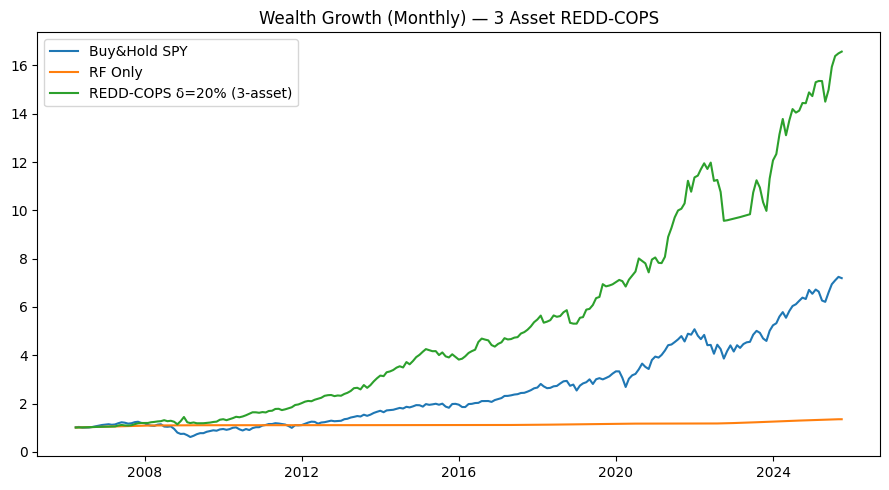

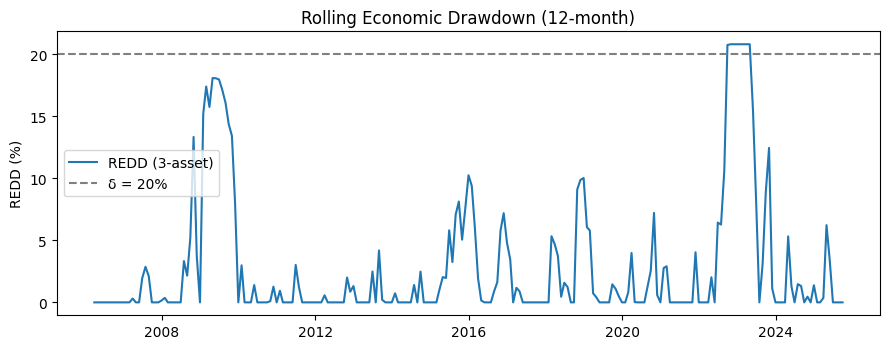

=== 3-Asset REDD-COPS (monthly) ===
Ann. Return:     16.30%
Ann. Volatility: 12.11%
Sharpe (RF):     1.13
Max Drawdown:    -20.12%
Max REDD:        20.80%
Avg REDD:        2.89%
Avg Exposure:    1.34
Max Exposure:    1.50


In [ ]:
#REDD-COPS for 3 risky assets

risky3 = ["SPY", "TLT", "DBC"]
ret_mat = m_rets[risky3].dropna(how="any")
rf_m    = m_rf.reindex(ret_mat.index).ffill()

# monthly freq parameters
DELTA    = 0.20     # REDD budget δ
H_WIN    = 12       # H-month window
REB_EVERY= 1        # rebalance every month
TR_COST  = 0.0005   # trading cost on turnover (optional)
W_CAP_TOT= 1.5      # cap on total risky exposure (optional)
EPS      = 1e-8     # ridge for Σ

def run_redd_cops_multi_3(ret_mat: pd.DataFrame,
                          rf: pd.Series,
                          delta: float = 0.20,
                          H: int = 12,
                          rebalance_every: int = 1,
                          tr_cost: float = 0.0,
                          w_cap_total: float | None = None,
                          eps: float = 1e-8) -> tuple[pd.Series, pd.DataFrame, pd.Series]:
    """
    Multi-asset REDD-COPS (3 assets) using empirical μ and Σ each month:
      q_t = μ_t + 0.5 * σ_t  (elementwise)
      x*_t = Σ_t^{-1} q_t
      scale_t = max(0, (1/(1-δ^2)) * ((δ - REDD_{t-1}) / (1 - REDD_{t-1})))
      x_t = max(0, scale_t * x*_t), optionally capped by sum(x_t) ≤ w_cap_total
    Wealth: W_t = W_{t-1} [ 1 + x_t^T r_t + (1 - 1^T x_t) r^F_t ]  (monthly simple returns)
    """
    idx = ret_mat.index
    rf  = rf.reindex(idx).fillna(0.0)

    W = pd.Series(1.0, index=idx)
    REDD = pd.Series(0.0, index=idx)
    w_hist = pd.DataFrame(0.0, index=idx, columns=ret_mat.columns)

    w_curr = np.zeros(ret_mat.shape[1], dtype=float)
    wealth = 1.0

    for t in range(len(idx)):
        tstamp = idx[t]

        # Rebalance once we have H months of history
        if t >= H and (t % rebalance_every == 0):
            window = ret_mat.iloc[t-H+1:t+1]
            mu = window.mean().values
            # covariance & sigma (monthly)
            cov = window.cov().values
            sig = np.sqrt(np.clip(np.diag(cov), 0.0, np.inf))

            # REDD_{t-1} computed from realized W
            REDD_hist = rolling_economic_drawdown(W.iloc[:t], rf.iloc[:t], H=H)
            redd_prev = float(REDD_hist.iloc[-1]) if len(REDD_hist) else 0.0

            # scaling factor (Eq. 5/6 spirit)
            scale = max(0.0, (1.0/(1.0 - delta**2)) * ((delta - redd_prev) / max(1e-12, (1.0 - redd_prev))))

            # direction via Σ^{-1} q   with q = μ + 0.5 σ
            q = mu + 0.5 * sig
            inv_cov = np.linalg.pinv(cov + np.eye(len(q))*eps)
            x_raw = inv_cov @ q

            # clamp non-negative
            x = np.maximum(0.0, scale * x_raw)

            # optional total risky cap
            if (w_cap_total is not None) and (x.sum() > w_cap_total) and (x.sum() > 0):
                x *= (w_cap_total / x.sum())

            # trading cost on turnover
            if tr_cost > 0:
                turnover = np.abs(x - w_curr).sum()
                wealth -= wealth * tr_cost * turnover

            w_curr = x

        # wealth update at month t
        r_vec = ret_mat.iloc[t].values if t < len(idx) else np.zeros_like(w_curr)
        rF    = rf.iloc[t]
        port_r = float(w_curr @ r_vec) + (1.0 - w_curr.sum()) * rF
        wealth *= (1.0 + port_r)

        W.iloc[t] = wealth
        w_hist.iloc[t] = w_curr
        # REDD at t (based on realized W)
        REDD.iloc[t] = rolling_economic_drawdown(W.iloc[:t+1], rf.iloc[:t+1], H=H).iloc[-1]

    return W.rename(f"REDD-COPS δ={int(delta*100)}% (3-asset)"), w_hist, REDD

# Run 3-asset REDD-COPS 
W_3, w_3, REDD_3 = run_redd_cops_multi_3(
    ret_mat=ret_mat,
    rf=rf_m,
    delta=DELTA,
    H=H_WIN,
    rebalance_every=REB_EVERY,
    tr_cost=TR_COST,
    w_cap_total=W_CAP_TOT,
    eps=EPS
)

# Benchmarks 
W_rf = (1 + rf_m).cumprod().rename("RF Only")
W_bh_spy = (1 + ret_mat["SPY"]).cumprod().rename("Buy&Hold SPY")

# plots
plt.figure(figsize=(9,5))
plt.plot(W_bh_spy, label=W_bh_spy.name)
plt.plot(W_rf,     label=W_rf.name)
plt.plot(W_3,      label=W_3.name)
plt.title("Wealth Growth (Monthly) — 3 Asset REDD-COPS")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,3.6))
plt.plot(100*REDD_3, label="REDD (3-asset)")
plt.axhline(100*DELTA, linestyle="--", color="gray", label=f"δ = {int(DELTA*100)}%")
plt.ylabel("REDD (%)"); plt.title(f"Rolling Economic Drawdown ({H_WIN}-month)")
plt.legend(); plt.tight_layout(); plt.show()

# annualized metrics
def _ann_return_from_wealth(W: pd.Series, periods_per_year=12) -> float:
    r = W.pct_change().dropna()
    return (1.0 + r.mean())**periods_per_year - 1.0

def _ann_vol_from_wealth(W: pd.Series, periods_per_year=12) -> float:
    r = W.pct_change().dropna()
    return r.std(ddof=1) * np.sqrt(periods_per_year)

def _sharpe_from_wealth(W: pd.Series, rf: pd.Series, periods_per_year=12) -> float:
    r  = W.pct_change().dropna()
    rf = rf.reindex(r.index).fillna(0.0)
    ex = r - rf
    vol = r.std(ddof=1)
    return (ex.mean()/vol)*np.sqrt(periods_per_year) if vol > 0 else np.nan

def _max_drawdown(W: pd.Series) -> float:
    return float((W/W.cummax() - 1.0).min())

print("=== 3-Asset REDD-COPS (monthly) ===")
print(f"Ann. Return:     {_ann_return_from_wealth(W_3):.2%}")
print(f"Ann. Volatility: {_ann_vol_from_wealth(W_3):.2%}")
print(f"Sharpe (RF):     {_sharpe_from_wealth(W_3, rf_m):.2f}")
print(f"Max Drawdown:    {_max_drawdown(W_3):.2%}")
print(f"Max REDD:        {REDD_3.max():.2%}")
print(f"Avg REDD:        {REDD_3.mean():.2%}")
print(f"Avg Exposure:    {w_3.sum(axis=1).mean():.2f}")
print(f"Max Exposure:    {w_3.sum(axis=1).max():.2f}")
